In this notebook file, I have been playing with geographic data and plotting modules. 
These codes might be messy and inefficient. 

In [1]:
import os
import geopandas
import rasterio
from rasterio import features, plot
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors

<AxesSubplot:>

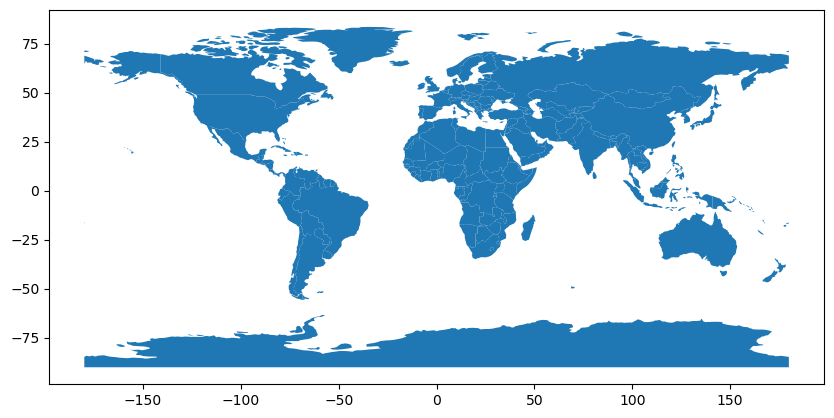

In [2]:
path_to_data = geopandas.datasets.get_path("naturalearth_lowres")
gdf = geopandas.read_file(path_to_data)

gdf.plot(figsize=(10, 10))


<AxesSubplot:>

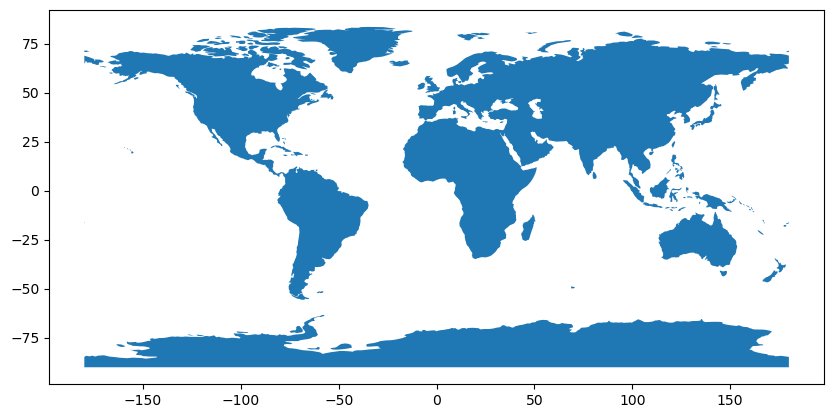

In [3]:
data = geopandas.read_file('./data/ne_110m_land/ne_110m_land.shp')
data.plot(figsize=(10, 10))


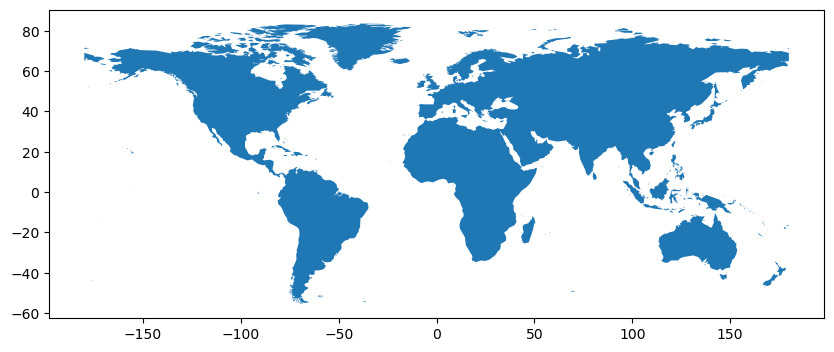

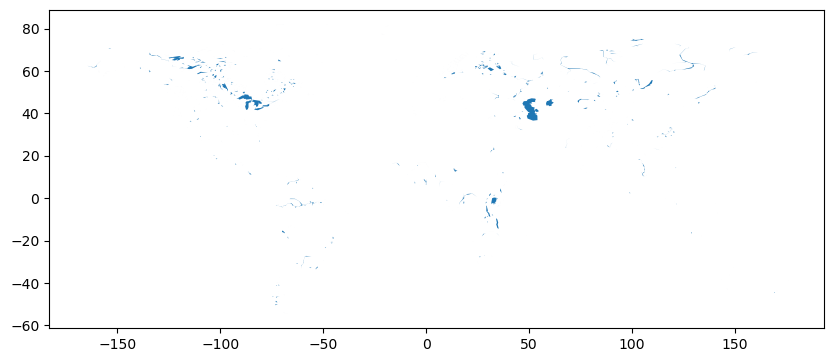

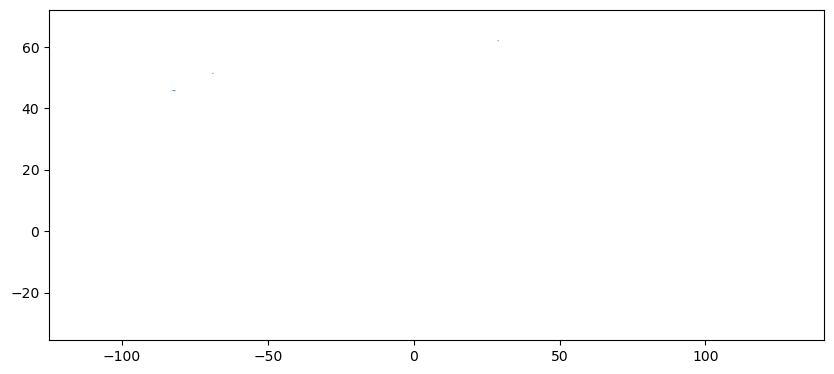

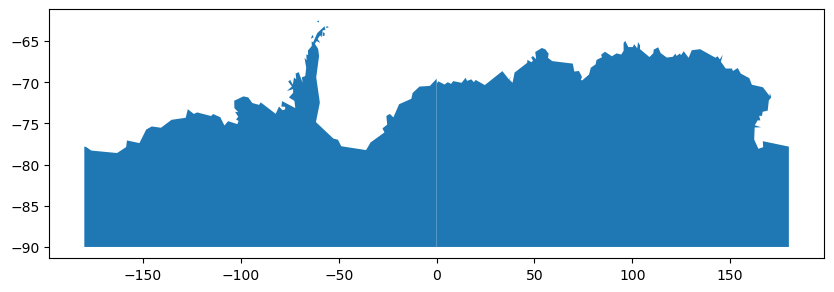

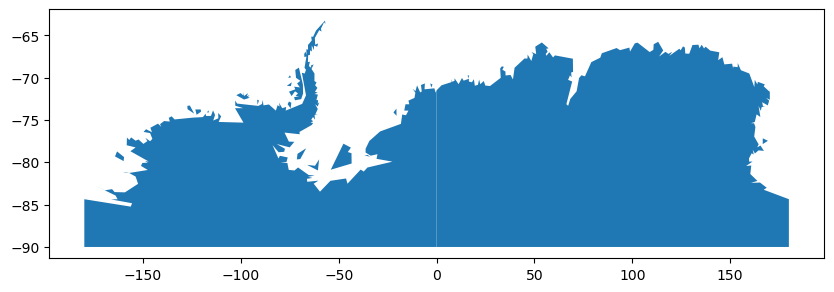

In [4]:
res = 'c'  # f, h, i, l, c

for i in range(1, 7):
    path = f'./data/gshhg-shp-2.3.7/GSHHS_shp/{res}/GSHHS_{res}_L{i}.shp'
    if os.path.exists(path):
        data = geopandas.read_file(path)
        data.plot(figsize=(10, 10))


In [5]:
with rasterio.open('./data/ETOPO//ETOPO_2022_v1_60s_N90W180_surface.tif') as dataset:
    # Read the dataset's valid data mask as a ndarray.
    mask = dataset.dataset_mask()

    # Extract feature shapes and values from the array.
    for geom, val in rasterio.features.shapes(
            mask, transform=dataset.transform):

        # Transform shapes from the dataset's own coordinate
        # reference system to CRS84 (EPSG:4326).
        geom = rasterio.warp.transform_geom(
            dataset.crs, 'EPSG:4326', geom, precision=6)

        # Print GeoJSON shapes to stdout.
        print(geom)


{'type': 'Polygon', 'coordinates': [[[-180.0, 90.0], [-180.0, -90.0], [180.0, -90.0], [180.0, 90.0], [-180.0, 90.0]]]}


21600 10800


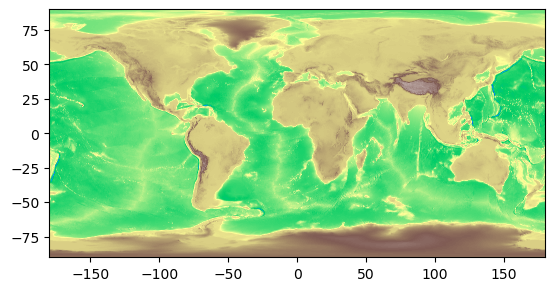

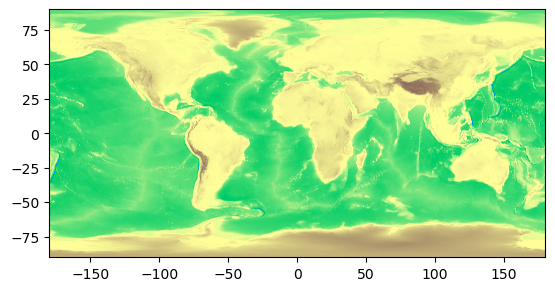

In [6]:
with rasterio.open('./data/ETOPO//ETOPO_2022_v1_60s_N90W180_surface.tif') as dataset:
    print(dataset.width, dataset.height)
    rasterio.plot.show(dataset, cmap='terrain')
    rasterio.plot.show(dataset, vmin=-12000, vmax=12000, cmap='terrain')


In [7]:
from rasterio.enums import Resampling
import rasterio.transform

upscale_factor = 1/10

with rasterio.open('./data/ETOPO//ETOPO_2022_v1_60s_N90W180_surface.tif') as dataset:

    # resample data to target shape
    ETOPO_lowres = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * upscale_factor),
            int(dataset.width * upscale_factor)
        ),
        resampling=Resampling.bilinear
    )

    # scale image transform
    transform = dataset.transform * dataset.transform.scale(
        (dataset.width / ETOPO_lowres.shape[-1]),
        (dataset.height / ETOPO_lowres.shape[-2])
    )
    rasterio.transform.Affine

ETOPO_lowres = ETOPO_lowres.squeeze()
resolution = ETOPO_lowres.shape
resolution


(1080, 2160)

In [13]:
vmax=np.max(ETOPO_lowres)
vmin=np.min(ETOPO_lowres)

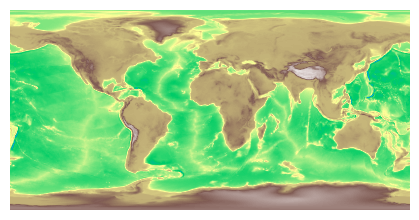

In [8]:
fig = plt.figure()
ax = plt.subplot()
ax.axis('off')
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
fig.set_size_inches(4, 2)
ax.imshow(ETOPO_lowres, cmap='terrain')
fig.savefig('./out/test.png', dpi=540)


In [9]:
"""
Source: https://github.com/13ff6/Topography_Map_Madagascar/blob/main/Mad_Regional_Map.py
"""


class FixPointNormalize(matplotlib.colors.Normalize):
    """ 
    Inspired by https://stackoverflow.com/questions/20144529/shifted-colorbar-matplotlib
    Subclassing Normalize to obtain a colormap with a fixpoint 
    somewhere in the middle of the colormap.

    This may be useful for a `terrain` map, to set the "sea level" 
    to a color in the blue/turquise range. 
    """

    def __init__(self, vmin=None, vmax=None, sealevel=0, col_val=0.21875, clip=False):
        # sealevel is the fix point of the colormap (in data units)
        self.sealevel = sealevel
        # col_val is the color value in the range [0,1] that should represent the sealevel.
        self.col_val = col_val
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.sealevel, self.vmax], [0, self.col_val, 1]
        return np.ma.masked_array(np.interp(value, x, y))


# Combine the lower and upper range of the terrain colormap with a gap in the middle
# to let the coastline appear more prominently.
# inspired by https://stackoverflow.com/questions/31051488/combining-two-matplotlib-colormaps
colors_undersea = plt.cm.terrain(np.linspace(0, 0.17, 56))
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 200))


# combine them and build a new colormap
colors = np.vstack((colors_undersea, colors_land))
cut_terrain_map = matplotlib.colors.LinearSegmentedColormap.from_list(
    'cut_terrain', colors)


cmap = plt.get_cmap('terrain')
norm = FixPointNormalize(sealevel=0, vmax=vmax, vmin=vmin)


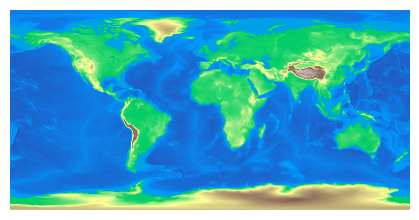

In [10]:
fig, ax = plt.subplots()
norm = FixPointNormalize(sealevel=0, vmax=vmax, vmin=vmin)

ax.axis('off')
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
fig.set_size_inches(4, 2)
ax.imshow(ETOPO_lowres, cmap=cut_terrain_map, norm=norm, extent=(-180, 180, -90, 90))

fig.savefig('./out/test.png', dpi=540)


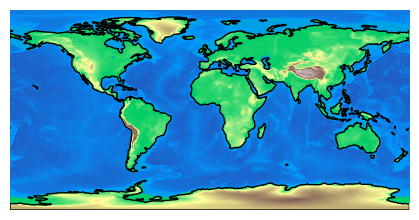

In [11]:
fig, ax = plt.subplots()

ax.axis('off')
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
fig.set_size_inches(4, 2)
ax.imshow(ETOPO_lowres, cmap=cut_terrain_map, norm=norm, extent=(-180, 180, -90, 90))

land_shp = geopandas.read_file('./data/ne_110m_land/ne_110m_land.shp')
land_shp.geometry.boundary.plot(ax=ax, edgecolor='black', linewidth = 1)

fig.savefig('./out/test.png', dpi=540)


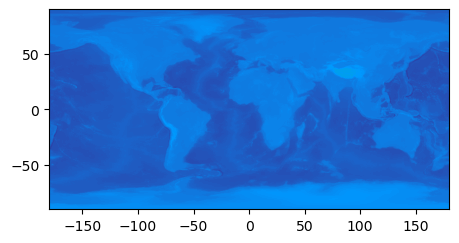

In [20]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()

ax.axis('off')
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
fig.set_size_inches(4, 2)

def animate(f):
    ax.clear()
    norm = FixPointNormalize(sealevel=f, vmax=vmax, vmin=vmin)
    return ax.imshow(ETOPO_lowres, cmap=cut_terrain_map, norm=norm, extent=(-180, 180, -90, 90))

anim = FuncAnimation(fig, animate, np.arange(0, 6000, 10))

anim.save('./out/anim.mp4', fps=60)

In [14]:
vmax, vmin

(6157.963, -9835.555)